<a href="https://colab.research.google.com/github/MbogoriL/text-classification/blob/main/Text_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#2F4F4F'>AfterWork Data Science: Text Classification with Python - Project</font>

## <font color='#2F4F4F'>Step 1. Business Understading </font>

### a) Specifying the Research Question

Build a text classification model that classifies a given text input as written in english or in dutch.

### b) Defining the Metric for Success

Build a classification model with an accuracy of score of atleast 85%.

### c) Understanding the Context 

You work as a Computational Linguist for a Global firm, collaborating with Engineers and
Researchers in Assistant and Research & Machine Intelligence to develop language
understanding models that improve our ability to understand and generate natural
language.

### d) Recording the Experimental Design

* Business Understanding
* Data Exploration
* Data Preparation
* Data Modeling and Evaluation
* Summary of Findings 
* Recommendation
* Challenges


## <font color='#2F4F4F'>Step 2. Data Importation</font>

In [1]:
# Importing the required libraries
# ---
# 
import pandas as pd # library for data manipulation
import numpy as np  # librariy for scientific computations
import re           # regex library to perform text preprocessing
import string       # library to work with strings
import nltk         # library for natural language processing
import scipy        # scientific computing 
import seaborn as sns # library for data visualisation
import warnings
warnings.filterwarnings('ignore')     #suppress warnings

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

# Library for Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja 
from textblob import TextBlob

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Library for Lemmatization
nltk.download('wordnet')
from textblob import Word

# Library for Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Library for TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 

# Library for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 541 kB 5.0 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=771e149dba8a71f9d21a40a2d881140ce247e230bbacfe300927c3a0b4ccbdcb
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers

In [2]:
# Custom Functions
# ---
#

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0 
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Subjectivity 
def get_subjectivity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [3]:
# loading and previewing the dataset
df = pd.read_csv('http://bit.ly/EnglishNDutchDs') 
df.sample(5)

,text,label
634,"juvenile leaves are lobed, reaching 70 cm (28 in) long he leaf veins and undersurface",en
829,De belangrijkste winkelstraat in Boulder is Pearl Street gedeeltelijk voetgangersgebied met veel winkels restaurants en,nl
865,He played for Indian Super League club Pune City in before returning to Charlton in,en
896,He first appeared on DOL a musical teleserye on ABSCBN as one of the band,en
985,In April Keating suffered a heart attack in New York City while en route to,en


## <font color='#2F4F4F'>Step 3. Data Exploration</font>

In [4]:
# check dataset shape
df.shape

(1069, 2)

Our dataset has 1069 records and 2 variables.

In [5]:
# preview variable datatypes
df.dtypes

text     object
label    object
dtype: object

Both variables have the data type object. This is fine for the text variable, however for the label, we will need to convert it to a numerical format. We will do this later.

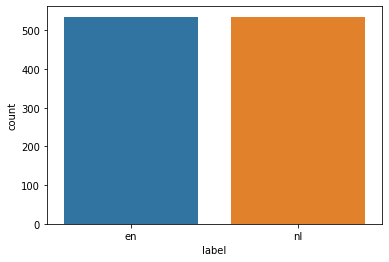

In [6]:
# plotting the distribution of label
sns.countplot(df['label']);

In [7]:
# investigating the label distribution
df['label'].value_counts()

nl    535
en    534
Name: label, dtype: int64

From above, we can see that our dataset is unbalanced thus we will need to sample equal no. of records for each label during data preparation to make a balanced dataset.

## <font color='#2F4F4F'>Step 4. Data Preparation</font>

### <font color='#2F4F4F'>3.1 Data Cleaning</font>

In [8]:
# check for duplicates
df.duplicated().sum()

10

There are 10 duplicates. We will need to drop these.

In [9]:
# check for missing values
df.isna().sum()

text     0
label    0
dtype: int64

No missing values found. 

In [10]:
# dropping our duplicates
df = df.drop_duplicates()
df.shape

(1059, 2)

In [11]:
# What values are in our label variable?
# ---
#
df.label.unique()

array(['en', 'nl'], dtype=object)

In [12]:
# sampling text with en 
df_en = df[df["label"] == 'en'] 
df_en = df_en.sample(200)

# sampling text with nl 
df_nl = df[df["label"] == 'nl'] 
df_nl = df_nl.sample(200)

# combining our dataframes
df = pd.concat([df_en, df_nl])
df.head()

,text,label
999,Hitman Howie Tee born Howard Thompson is an Englishborn hiphop DJ and producer of West,en
617,"Andy Everson (born 1972) is a contemporary Native American Artist born in Comox, British Columbia.",en
934,He was the penultimate minister of the Government Information Office from to a post he,en
685,"the Nuremberg Opera, until the outbreak of 2nd world war. She was a member of",en
681,Theatre (Oslo) for the royals. At the age of 21 she got the Ruud-scholarship for,en


In [13]:
# investigating the label distribution
df['label'].value_counts()

en    200
nl    200
Name: label, dtype: int64

We now have our balanced dataset. 

### <font color='#2F4F4F'> 3.2 Text Cleaning</font>

In [14]:
# We will create a custom function that will contain all the text cleaning 
# techniques. We can then reuse the same function for cleaning new data
# without rewriting the code.
# ---
def text_cleaning(text):
  # Removing url/links
  df['text'] = df.text.apply(lambda x: re.sub(r'http\S+|www\S+|https\S+','', str(x)))

  # Removing @ and # characters and replacing them with space
  df['text'] = df.text.str.replace('#',' ')
  df['text'] = df.text.str.replace('@',' ') 

  # Conversion to lowercase 
  df['text'] = df.text.apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Removing punctuation characters
  df['text'] = df.text.str.replace('[^\w\s]','')

  # Removing stop words
  df['text'] = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # Lemmatization
  df['text'] = df.text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [15]:
# Applying the text_cleaning function to our dataframe.
# ---
# NB: This process may take 5-10 min.
# ---
#
df['text'].apply(text_cleaning)
df.sample(5)

,text,label
838,de wetenschappelijke naam van de soort werd voor het eerst geldig gepubliceerd door mccarty,nl
958,stone flaming thermaling application high temperature surface stone,en
866,released end season johnson signed shortterm contract bromley,en
117,fifth europe49 highly world college desirable21 powerful20,en
727,hij behoorde tot de honderd scholen van het denken en dus een belangrijke filosofisch,nl


### <font color='#2F4F4F'> 3.3 Feature Engineering</font>

In [16]:
# We will create a custom function that will contain all the 
# feature engineering techniques. We can then use this function 
# for cleaning new data. 
# ---

def feature_engineering(text):
  # Length of tweet
  df['length_of_tweet'] = df.text.str.len()

  # Word count 
  df['word_count'] = df.text.apply(lambda x: len(str(x).split(" ")))

  # Word density (Average no. of words / tweet)
  df['avg_word_length'] = df.text.apply(lambda x: avg_word(x)) 
  
  # Noun Count
  df['noun_count'] = df.text.apply(lambda x: pos_check(x, 'noun'))

  # Verb Count
  df['verb_count'] = df.text.apply(lambda x: pos_check(x, 'verb'))

  # Adjective Count / Tweet
  df['adj_count'] = df.text.apply(lambda x: pos_check(x, 'adj'))

  # Adverb Count / Tweet
  df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

  # Pronoun 
  df['pron_count'] = df.text.apply(lambda x: pos_check(x, 'pron'))

  # Subjectivity 
  df['subjectivity'] = df.text.apply(get_subjectivity)

  # Polarity
  df['polarity'] = df.text.apply(get_polarity)

In [17]:
# Applying the custom feature engineering function to our dataframe.
# This process may take 2-5 min.
# ---
#
df.text.apply(feature_engineering)
df.sample(5)

,text,label,length_of_tweet,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
436,nog dienstdoen al de de al zeegebied overlevering de kunnen dus gebakken honger veel trojaanse,nl,94,15,5.333333,7,2,1,0,0,0.0,0.0
53,october ifp party legislature official hlabisa 2017 general pledged,en,67,9,6.555556,4,1,2,0,0,0.0,0.0
37,event umhlanga purely celebrate worn also established,en,53,7,6.714286,3,1,1,2,0,0.0,0.0
784,hij probeerde tevergeefs een opstand te organiseren leefde enkele maanden op de vlucht en pleegde,nl,97,15,5.533333,6,2,4,0,0,0.0,0.0
558,pyrophosphate originally prepared heating phosphate pyro greek meaning fire generally,en,85,10,7.600000,5,2,1,2,0,0.0,0.0


In [18]:
# Performing further feature engineering techniques
# ---
#
# Feature Construction: Word Level N-Gram TF-IDF Feature 
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,3),  stop_words= 'english')
df_word_vect = tfidf.fit_transform(df.text) 

# Feature Construction: Character Level N-Gram TF-IDF 
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char', ngram_range=(1,3),  stop_words= 'english')
df_char_vect = tfidf.fit_transform(df.text)


In [19]:
# Let's prepare the constructed features for modeling
# ---
# We will select all variables but the target (which is the label) and text variables 
# ---
#  
X_metadata = np.array(df[df.columns.difference(['label', 'text'])])
X_metadata

array([[ 2.        ,  1.        ,  5.72727273, ...,  0.        ,
         2.        , 11.        ],
       [ 7.        ,  0.        ,  6.25      , ...,  0.        ,
         1.        , 12.        ],
       [ 0.        ,  0.        ,  8.33333333, ...,  0.        ,
         0.        ,  6.        ],
       ...,
       [ 1.        ,  0.        ,  5.6       , ...,  0.        ,
         2.        , 10.        ],
       [ 1.        ,  0.        ,  5.28571429, ...,  0.        ,
         0.        , 14.        ],
       [ 2.        ,  0.        ,  4.84615385, ...,  0.        ,
         1.        , 13.        ]])

In [20]:
# We combine our two tfidf (sparse) matrices and X_metadata
# ---
#
X = scipy.sparse.hstack([df_word_vect, df_char_vect, X_metadata])
X

<400x2010 sparse matrix of type '<class 'numpy.float64'>'
	with 52325 stored elements in COOrdinate format>

In [21]:
# Label Preparation i.e. replacing categorial values with numerical ones
# ---  
y = np.array(df['label'].replace(['nl', 'en'], ['0','1']))
y

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1

##  <font color='#2F4F4F'>Step 5. Data Modeling</font>

We will carry out 10 types of classification analysis, namely:
1.  Logistic Regression
3.  Decision Trees Classification
4.  Support Vector Machine (SVM) Classification
5. K-Nearest Neighbors (KNN) Classification
6.  Gaussian Naive Bayes (NB) Classification
7.  BaggingClassifier
8.  RandomForestClassifier
9.  AdaBoostClassifier
10. GradientBoostingClassifier

We use their default parameters then compare the different classification models to assess the best performing one(s). 

In [ ]:
# splitting into 80-20 train-test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# loading our classification libraries
from sklearn.linear_model import LogisticRegression      # Logistic Regression Classifier
from sklearn.tree import DecisionTreeClassifier          # Decision Tree Classifier
from sklearn.svm import SVC                              # SVM Classifier
from sklearn.naive_bayes import MultinomialNB            # Naive Bayes Classifier
from sklearn.neighbors import KNeighborsClassifier       # KNN Classifier

# Ensemble classifiers
from sklearn.ensemble import BaggingClassifier           # Bagging Meta-Estimator Classifier
from sklearn.ensemble import RandomForestClassifier      # RandomForest Classifier 
from sklearn.ensemble import AdaBoostClassifier          # AdaBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier  # AdaBoost GradientBoostingClassifier
import xgboost as xgb                                    # Importing the XGBoost library

# instantiating our classifiers
logistic_classifier = LogisticRegression(solver='saga', max_iter=800, multi_class='multinomial')
decision_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC()
knn_classifier = KNeighborsClassifier()
naive_classifier = MultinomialNB() 

bagging_meta_classifier = BaggingClassifier()
random_forest_classifier = RandomForestClassifier()
ada_boost_classifier = AdaBoostClassifier(random_state=42)
gbm_classifier = GradientBoostingClassifier(random_state=42) 
xg_boost_classifier = xgb.XGBClassifier() 


# fitting our classifiers to the training data
logistic_classifier.fit(X_train, y_train)
decision_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)
naive_classifier.fit(X_train, y_train) 

bagging_meta_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)
ada_boost_classifier.fit(X_train, y_train)
gbm_classifier.fit(X_train, y_train)
xg_boost_classifier.fit(X_train, y_train)

# making predictions
logistic_y_prediction = logistic_classifier.predict(X_test) 
decision_y_prediction = decision_classifier.predict(X_test) 
svm_y_prediction = svm_classifier.predict(X_test) 
knn_y_prediction = knn_classifier.predict(X_test) 
naive_y_prediction = naive_classifier.predict(X_test)  

bagging_y_classifier = bagging_meta_classifier.predict(X_test) 
random_forest_y_classifier = random_forest_classifier.predict(X_test) 
ada_boost_y_classifier = ada_boost_classifier.predict(X_test)
gbm_y_classifier = gbm_classifier.predict(X_test)
xg_boost_y_classifier = xg_boost_classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
# Evaluating the Models
from sklearn.metrics import accuracy_score

# Accuracy scores
#
print("Logistic Regression Classifier", accuracy_score(logistic_y_prediction, y_test))
print("Decision Trees Classifier", accuracy_score(decision_y_prediction, y_test))
print("SVN Classifier", accuracy_score(svm_y_prediction, y_test))
print("KNN Classifier", accuracy_score(knn_y_prediction, y_test))
print("Naive Bayes Classifier", accuracy_score(naive_y_prediction, y_test))
 
print("Bagging Classifier", accuracy_score(bagging_y_classifier, y_test))
print("Random Forest Classifier", accuracy_score(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", accuracy_score(ada_boost_y_classifier, y_test))
print("GBM Classifier", accuracy_score(gbm_y_classifier, y_test))
print("XGBoost Classifier", accuracy_score(xg_boost_y_classifier, y_test))

Logistic Regression Classifier 0.9625
Decision Trees Classifier 0.9625
SVN Classifier 0.8375
KNN Classifier 0.9375
Naive Bayes Classifier 0.925
Bagging Classifier 0.975
Random Forest Classifier 1.0
Ada Boost Classifier 1.0
GBM Classifier 0.975
XGBoost Classifier 0.9875


Your observation about the performance of the models...

In [ ]:
# Confusion matrices
from sklearn.metrics import confusion_matrix

print('Logistic Regression Classifier:') 
print(confusion_matrix(logistic_y_prediction, y_test))

print('Decision Trees Classifier:')
print(confusion_matrix(decision_y_prediction, y_test))

print('SVN Classifier:')
print(confusion_matrix(svm_y_prediction, y_test))

print('KNN Classifier:')
print(confusion_matrix(knn_y_prediction, y_test))

print('Naive Bayes Classifier:')
print(confusion_matrix(naive_y_prediction, y_test))
 
print('Bagging Classifier:')
print(confusion_matrix(bagging_y_classifier, y_test))

print('Random Forest Classifier:')
print(confusion_matrix(random_forest_y_classifier, y_test))

print('Ada Boost Classifier:')
print(confusion_matrix(ada_boost_y_classifier, y_test))

print('GBM Classifier:')
print(confusion_matrix(gbm_y_classifier, y_test))

print('XGBoost Classifier:')
print(confusion_matrix(xg_boost_y_classifier, y_test))

Logistic Regression Classifier:
[[35  2]
 [ 1 42]]
Decision Trees Classifier:
[[34  1]
 [ 2 43]]
SVN Classifier:
[[35 12]
 [ 1 32]]
KNN Classifier:
[[34  3]
 [ 2 41]]
Naive Bayes Classifier:
[[36  6]
 [ 0 38]]
Bagging Classifier:
[[35  1]
 [ 1 43]]
Random Forest Classifier:
[[36  0]
 [ 0 44]]
Ada Boost Classifier:
[[36  0]
 [ 0 44]]
GBM Classifier:
[[35  1]
 [ 1 43]]
XGBoost Classifier:
[[35  0]
 [ 1 44]]


In [ ]:
# Classification Reports
from sklearn.metrics import classification_report
print("Logistic Regression Classifier", classification_report(logistic_y_prediction, y_test))
print("Decision Trees Classifier", classification_report(decision_y_prediction, y_test))
print("SVM Classifier", classification_report(svm_y_prediction, y_test))
print("KNN Classifier", classification_report(knn_y_prediction, y_test))
print("Naive Bayes Classifier", classification_report(naive_y_prediction, y_test))
 
print("Bagging Classifier", classification_report(bagging_y_classifier, y_test))
print("Random Forest Classifier", classification_report(random_forest_y_classifier, y_test))
print("Ada Boost Classifier", classification_report(ada_boost_y_classifier, y_test))
print("GBM Classifier", classification_report(gbm_y_classifier, y_test))
print("XGBoost Classifier", classification_report(xg_boost_y_classifier, y_test))

Logistic Regression Classifier               precision    recall  f1-score   support

           0       0.97      0.95      0.96        37
           1       0.95      0.98      0.97        43

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80

Decision Trees Classifier               precision    recall  f1-score   support

           0       0.94      0.97      0.96        35
           1       0.98      0.96      0.97        45

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80

SVM Classifier               precision    recall  f1-score   support

           0       0.97      0.74      0.84        47
           1       0.73      0.97      0.83        33

    accuracy                           0.84        80
   macro avg       0.85      0.86      0.84        80
we

## <font color='#2F4F4F'>Step 6. Summary of Findings and Recommendation</font>

Our best performing models were random forest and ada boost classification. To improve our model, we can try perfoming other text processing techniques that would better prepare our data for fitting our model. We can also perform hyperparameter tuning and sample a balanced dataset.

## <font color='#2F4F4F'>Step 7. Challenging our Solution</font>